In [9]:
import numpy as np
import torch
import torchvision.transforms as transforms
from Mydataset import Mydataset
import os
import matplotlib.pyplot as plt

In [21]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"dataset/test_dataset.npy")
datasets = Mydataset(data_path)
img, lable = datasets.__getitem__(1)
img,lable

(<PIL.Image.Image image mode=RGB size=448x448 at 0x7FB9DE42FB80>,
 tensor([53.]))

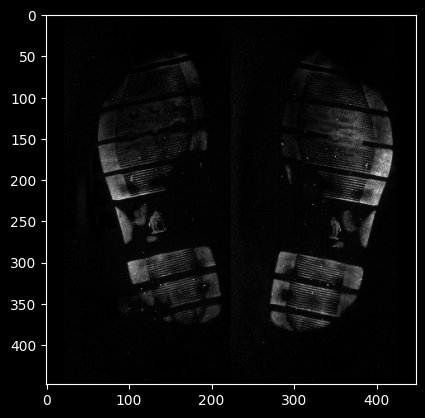

In [10]:
plt.imshow(img)

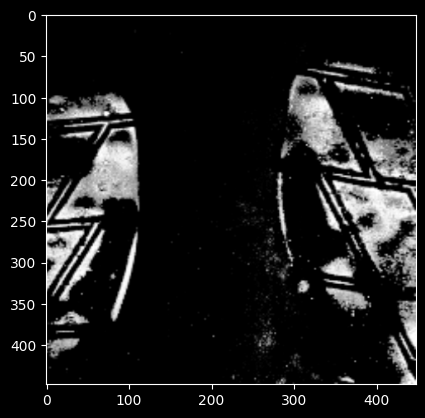

In [74]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(448),])
                                    #  transforms.RandomHorizontalFlip()])
datset = Mydataset(data_path,transform=data_transform)
image_t, lable_t = datset.__getitem__(0)
image_t,lable
plt.imshow(image_t)

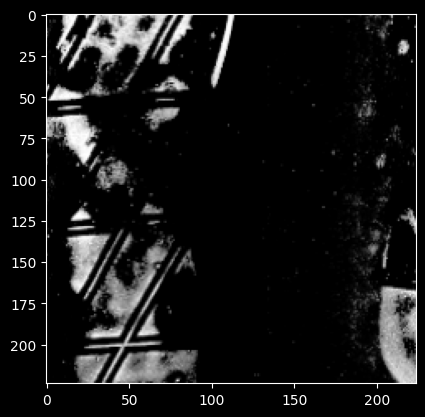

In [23]:
plt.imshow(image_t)

In [85]:
from model.resnet import resnet18,resnet50
from torchsummary import summary

In [86]:
device = torch.device("cpu")
net = resnet50()
# summary(net,(3,448,448))

In [94]:
def print_shapes(module, input, output):
    print(f"Module: {module.__class__.__name__}")
    print(f"Input shape: {str(input[0].shape)}")
    print(f"Output shape: {str(output.shape)}")
    print("")

# 注册钩子
hooks = []
for layer in net.children():
    hook = layer.register_forward_hook(print_shapes)
    hooks.append(hook)

# 使用模型进行推理
input_data = torch.randn(1, 3, 224, 224)  # 例如，3通道的224x224图像
output = net(input_data)

# 移除钩子
for hook in hooks:
    hook.remove()

Module: Conv2d
Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 64, 112, 112])

Module: BatchNorm2d
Input shape: torch.Size([1, 64, 112, 112])
Output shape: torch.Size([1, 64, 112, 112])

Module: ReLU
Input shape: torch.Size([1, 64, 112, 112])
Output shape: torch.Size([1, 64, 112, 112])

Module: MaxPool2d
Input shape: torch.Size([1, 64, 112, 112])
Output shape: torch.Size([1, 64, 56, 56])

Module: Sequential
Input shape: torch.Size([1, 64, 56, 56])
Output shape: torch.Size([1, 256, 56, 56])

Module: Sequential
Input shape: torch.Size([1, 256, 56, 56])
Output shape: torch.Size([1, 512, 28, 28])

Module: Sequential
Input shape: torch.Size([1, 512, 28, 28])
Output shape: torch.Size([1, 1024, 14, 14])

Module: Sequential
Input shape: torch.Size([1, 1024, 14, 14])
Output shape: torch.Size([1, 2048, 7, 7])

Module: AdaptiveAvgPool2d
Input shape: torch.Size([1, 2048, 7, 7])
Output shape: torch.Size([1, 2048, 1, 1])

Module: Sequential
Input shape: torch.Size([1, 2048])
O

In [90]:
import torch.nn as nn
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((1, 1))
input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
# target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)

torch.Size([1, 64, 1, 1])

In [98]:
input_data = torch.randn(1,3,448,448)
model = resnet50()
output_data = model(input_data)
output_data

tensor([[-0.0067]], grad_fn=<AddmmBackward0>)

In [110]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    print(x.ndim)
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    print(shape)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    print(random_tensor)
    random_tensor.floor_()  # binarize
    print(x.div(keep_prob))
    output = x.div(keep_prob) * random_tensor
    return output

In [113]:
help(torch.div)

Help on built-in function div:

div(...)
    div(input, other, *, rounding_mode=None, out=None) -> Tensor
    
    Divides each element of the input ``input`` by the corresponding element of
    :attr:`other`.
    
    .. math::
        \text{out}_i = \frac{\text{input}_i}{\text{other}_i}
    
    .. note::
        By default, this performs a "true" division like Python 3.
        See the :attr:`rounding_mode` argument for floor division.
    
    Supports :ref:`broadcasting to a common shape <broadcasting-semantics>`,
    :ref:`type promotion <type-promotion-doc>`, and integer, float, and complex inputs.
    Always promotes integer types to the default scalar type.
    
    Args:
        input (Tensor): the dividend
        other (Tensor or Number): the divisor
    
    Keyword args:
        rounding_mode (str, optional): Type of rounding applied to the result:
    
            * None - default behavior. Performs no rounding and, if both :attr:`input` and
              :attr:`other` a

In [111]:
input_data = torch.randn(3,224,224)
out_put = drop_path(input_data,0.2,True)

3
(3, 1, 1)
tensor([[[1.7621]],

        [[0.8379]],

        [[1.7790]]])
tensor([[[ 4.8102e-01,  1.7707e+00,  1.2247e+00,  ...,  6.4358e-01,
          -1.5707e-01, -7.3735e-01],
         [ 2.6698e+00, -1.5790e+00,  1.3801e+00,  ..., -1.4801e-01,
          -2.4403e+00,  1.2660e+00],
         [-8.0403e-01, -9.9141e-01,  4.6778e-01,  ..., -2.6532e-01,
          -1.9099e-01,  3.9457e-01],
         ...,
         [-1.7507e+00, -9.1680e-01, -5.4145e-01,  ...,  6.0536e-01,
           4.6269e-01, -5.2765e-01],
         [-1.2373e+00, -1.2114e+00,  2.0186e+00,  ...,  3.2767e-01,
          -2.4648e-01, -1.7211e+00],
         [-1.4380e+00,  3.1755e-01,  1.1264e+00,  ..., -1.5398e+00,
          -1.7151e+00, -7.4532e-01]],

        [[-2.2215e-01, -3.5130e-01, -1.4479e-01,  ...,  2.6510e+00,
          -1.2301e+00,  6.9367e-01],
         [-1.6169e+00, -5.8210e-01, -1.1827e+00,  ..., -5.0701e-02,
          -2.5525e+00,  4.4499e+00],
         [-5.7166e-01, -9.8622e-01,  1.2208e+00,  ..., -8.5615e-01,
 

In [115]:
help(torch.mul_)

AttributeError: module 'torch' has no attribute 'mul_'

In [117]:
linear = nn.Linear(10,1)
print(linear.weight.data, linear.weight.data.shape, linear.bias.data,linear.bias.data.shape)


(tensor([[-0.2671, -0.2614,  0.1200,  0.2857,  0.3140, -0.0171,  0.2448,  0.0945,
           0.1043,  0.1933]]),
 torch.Size([1, 10]),
 tensor([0.0851]),
 torch.Size([1]))